In [1]:
from helper_fun import *
HERE = Path(_dh[-1])
DATA = HERE / "data"

2024-08-08 23:28:41.697640: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
compounds = pd.read_csv("COVID_MOONSHOT/covid_submissions_all_info.csv", header = 0, usecols=["CID", "SMILES","r_avg_IC50", "f_avg_IC50"])
compounds.dropna(axis=0, how="any", subset = ["r_avg_IC50", "f_avg_IC50"], inplace=True)
compounds.drop(["r_avg_IC50", "f_avg_IC50"], axis=1)
compounds.drop_duplicates("CID", keep="first", inplace=True)
compounds.drop_duplicates("SMILES", keep="first", inplace=True)
print(f"Initial Number of Molecules: {len(compounds)}")
compounds.head()

Initial Number of Molecules: 529


,SMILES,CID,r_avg_IC50,f_avg_IC50
35,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,DAR-DIA-23aa0b97-19,14.641091,26.719515
36,O=C(Cc1cncc2ccccc12)Nc1ccccc1,DAR-DIA-23aa0b97-20,45.077469,57.590417
126,Cc1c(N)cncc1NC(=O)Cc1cccc(Cl)c1,TRY-UNI-714a760b-3,8.201698,4.222340
129,Cc1ccncc1NC(=O)Cc1cccc(Cl)c1,TRY-UNI-714a760b-6,13.895165,24.581194
135,Cc1ccncc1NC(=O)Nc1cccc(Cl)c1,TRY-UNI-714a760b-12,45.689263,64.508813


In [3]:
PandasTools.AddMoleculeColumnToFrame(compounds, "SMILES")
compounds["molecular_weight"] = compounds["ROMol"].apply(Descriptors.ExactMolWt)
compounds["n_hba"] = compounds["ROMol"].apply(Descriptors.NumHAcceptors)
compounds["n_hbd"] = compounds["ROMol"].apply(Descriptors.NumHDonors)
compounds["logp"] = compounds["ROMol"].apply(Descriptors.MolLogP)

#Add pIC50 columns
compounds["f_avg_pIC50"] = compounds.apply(lambda x: convert_ic50_to_pic50(x.f_avg_IC50), axis=1)
compounds["r_avg_pIC50"] = compounds.apply(lambda x: convert_ic50_to_pic50(x.r_avg_IC50), axis=1)

#Delete IC50 columns
compounds.drop(["r_avg_IC50", "f_avg_IC50"], axis=1, inplace=True)

compounds.head()

,SMILES,CID,ROMol,molecular_weight,n_hba,n_hbd,logp,f_avg_pIC50,r_avg_pIC50
35,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,DAR-DIA-23aa0b97-19,<rdkit.Chem.rdchem.Mol object at 0x1683ef220>,287.105862,3,1,3.28768,4.573171,4.834427
36,O=C(Cc1cncc2ccccc12)Nc1ccccc1,DAR-DIA-23aa0b97-20,<rdkit.Chem.rdchem.Mol object at 0x1683ee1f0>,262.110613,2,1,3.41600,4.239650,4.346040
126,Cc1c(N)cncc1NC(=O)Cc1cccc(Cl)c1,TRY-UNI-714a760b-3,<rdkit.Chem.rdchem.Mol object at 0x1683ee180>,275.082540,3,2,2.80682,5.374447,5.086096
129,Cc1ccncc1NC(=O)Cc1cccc(Cl)c1,TRY-UNI-714a760b-6,<rdkit.Chem.rdchem.Mol object at 0x1683ee110>,260.071641,2,1,3.22462,4.609397,4.857136
135,Cc1ccncc1NC(=O)Nc1cccc(Cl)c1,TRY-UNI-714a760b-12,<rdkit.Chem.rdchem.Mol object at 0x1683ee0a0>,261.066890,2,2,3.68742,4.190381,4.340186


In [4]:
compounds["Ro5_fulfilled"] = compounds["SMILES"].apply(filter_ro5_properties)
compounds = compounds[compounds["Ro5_fulfilled"] == True]
print(f"Number of molecules that satisfy Ro5: {len(compounds)}")

Number of molecules that satisfy Ro5: 471


In [5]:
# Delete molecules that have identical SMILES and ROMol and f_avg_pIC50 columns
compounds.drop_duplicates(subset=["SMILES", "ROMol", "molecular_weight", "f_avg_pIC50", "r_avg_pIC50"], keep="first", inplace=True)
print(f"Number of molecules after removing duplicates: {len(compounds)}")

Number of molecules after removing duplicates: 471


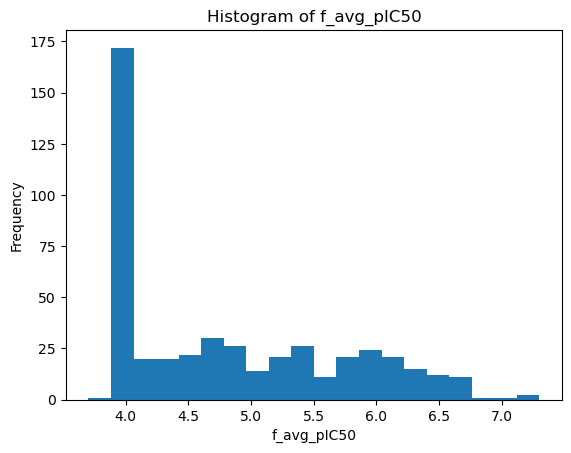

In [6]:
# plot histogram of f_avg_pIC50 with 20 bins
plt.hist(compounds["f_avg_pIC50"], bins=20)
plt.xlabel("f_avg_pIC50")
plt.ylabel("Frequency")
plt.title("Histogram of f_avg_pIC50")
plt.show()


In [7]:
# export the dataframe to a csv file
compounds.to_csv("COVID_MOONSHOT/compounds_filtered.csv", index=False)